In [2]:
import pickle
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from load import *
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import world_to_camera_dict
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test

# declare data parameters
par = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', #mac/ubuntu path format
        #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
         'out_dir'        : '/data/LiftPose3D/fly_tether/fixed_cams',
         'train_subjects' : [1,2,3,4,5],
         'test_subjects'  : [6,7],
         'actions'        : ['all'],
         'cam_id'         : [1,5]}

#load
tri = pickle.load(open(os.path.join(par['out_dir'],'retriangulation.pkl'),'rb'))

#lifting error
test_2d = load_2D(par["data_dir"],par,cam_id=par['cam_id'],subjects=par["test_subjects"],actions=par["actions"])
test_3d, kp, rcams_test = load_3D(par["data_dir"],par,cam_id=par['cam_id'],subjects=par["test_subjects"],actions=par["actions"])
test_3d = world_to_camera_dict(test_3d, rcams_test)
    
#normalize test data
test_2d, test_3d, stat_2d, stat_3d = set_test_data(par['out_dir'], test_2d, test_3d, kp.copy())

#test data on network
lp3d_test(par["out_dir"],test_2d, test_3d, kp.copy())
    
#load statistics and test results
lift_tar, lift_out, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)

absdiff = np.abs(lift_tar - lift_out)
lift_error = absdiff.mean(2)

#triangulation error
tri_3cam  = tri[(0, 1, 2, 4, 5, 6)]
tri_2cam = tri[(0, 1, 4, 6)]
tri_error = np.abs(tri_3cam - tri_2cam).mean(2)
nframes = tri_error.shape[0]

#Lift error
lift_error = lift_error[:len(tri_error)]

#average over limbs
tri_error = (tri_error[:,1:5] + tri_error[:,6:10] + tri_error[:,11:15] )/3
lift_error = (lift_error[:,1:5] + lift_error[:,6:10] + lift_error[:,11:15] )/3

#add overall error
tri_error = np.hstack((tri_error,np.mean(tri_error,axis=1)[:,None]))
lift_error = np.hstack((lift_error,np.mean(lift_error,axis=1)[:,None]))

#make pandas dataframe
tri_error=tri_error.flatten()
lift_error=lift_error.flatten()
error = np.concatenate((tri_error,lift_error))
error = pd.DataFrame({'joint': ['coxa-femur', 'femur-tibia', 'tibia-tarsus', 'tarsus-tip', 'overall'] * nframes * 2,
                   'method': ['tri' for i in range(len(tri_error))] + ['lift' for i in range(len(tri_error))],
                   'error': error})

[main.py:334]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/fixed_cams
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.33M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/fixed_cams/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 18 | err: 0.05912625673696869)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/fly_tether/fixed_cams/test_results.pth.tar


(0.0, 0.1)

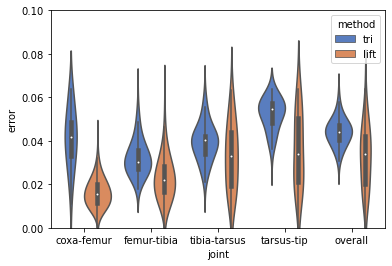

In [6]:
q = error.quantile(q=0.95)
error = error[error['error']<q[0]]

fig = plt.figure()
sns.violinplot(x="joint", y="error", hue="method", data=error, palette="muted",bw=0.7,ax=plt.gca())
plt.ylim(0, 0.1)